In [1]:
import sys
sys.path.append('../../')

import numpy as np

In [2]:
from holisticai.benchmark.tasks import task_name, get_task

print(task_name)

['binary_classification', 'multiclass_classification', 'regression', 'clustering', 'recommender']


In [3]:
# load a task
task = get_task("binary_classification")

In [4]:
# benchmark for the task by type
data = task.benchmark(type='preprocessing')
data

Dataset,Mean,adult,law_school
Mitigator,,,
LearningFairRepresentation,0.050262,0.092425,0.008099
Reweighing,0.112708,0.114098,0.111319
DisparateImpactRemover,0.135976,0.132802,0.139150
CorrelationRemover,0.152308,0.157080,0.147535


In [5]:
from holisticai.utils.transformers.bias import BMPreprocessing as BMPre

class MyMitigator(BMPre):

    def __init__(self, alpha=1):
        self.alpha = alpha

    def fit(self, X: np.ndarray, group_a: np.ndarray, group_b: np.ndarray):
        """
        Fit.

        Parameters
        ----------
        X : matrix-like
            Input data
        group_a : array-like
            Group membership vector (binary)
        group_b : array-like
            Group membership vector (binary)

        Return
        ------
            Self
        """
        params = self._load_data(X=X, group_a=group_a, group_b=group_b)
        X = params["X"]
        group_a = params["group_a"]
        group_b = params["group_b"]

        sensitive_features = np.stack([group_a, group_b], axis=1).astype(np.int32)
        self.sensitive_mean_ = sensitive_features.mean()
        sensitive_features_center = sensitive_features - self.sensitive_mean_
        self.beta_, _, _, _ = np.linalg.lstsq(sensitive_features_center, X, rcond=None)
        self.X_shape_ = X.shape

        return self

    def transform(self, X: np.ndarray, group_a: np.ndarray, group_b: np.ndarray):

        """
        Description
        ----------
        Transform X by applying the correlation remover.

        Parameters
        ----------
        X : matrix-like
            Input matrix
        group_a : array-like
            Group membership vector (binary)
        group_b : array-like
            Group membership vector (binary)
        Returns
        -------
            np.ndarray
        """

        params = self._load_data(X=X, group_a=group_a, group_b=group_b)
        X = params["X"]
        group_a = params["group_a"]
        group_b = params["group_b"]

        sensitive_features = np.stack([group_a, group_b], axis=1).astype(np.int32)
        self.sensitive_mean_ = sensitive_features.mean()
        sensitive_features_center = sensitive_features - self.sensitive_mean_
        X_filtered = X - sensitive_features_center.dot(self.beta_)
        X = np.atleast_2d(X)
        X_filtered = np.atleast_2d(X_filtered)
        return self.alpha * X_filtered + (1 - self.alpha) * X

    def fit_transform(
        self,
        X: np.ndarray,
        group_a: np.ndarray,
        group_b: np.ndarray,
    ):
        """
        Fit and transform

        Description
        ----------
        Fit and transform

        Parameters
        ----------
        X : matrix-like
            Input data
        group_a : array-like
            Group membership vector (binary)
        group_b : array-like
            Group membership vector (binary)

        Return
        ------
            Self
        """
        return self.fit(X, group_a, group_b).transform(X, group_a, group_b)


In [6]:
my_mitigator = MyMitigator()

task.run_benchmark(mitigator = my_mitigator, type = 'preprocessing')

Binary Classification Benchmark initialized for MyMitigator


100%|██████████| 4/4 [00:20<00:00,  5.02s/it]


In [7]:
data = task.evaluate_table()
data

Benchmark Table: the values are |frac{1}{M}\sum_{i}^{M}(StatiticalParity_{i}))| by dataset, 
 where M is the number of models trained in benchmark.


Dataset,Mean,adult,compas_recidivism,german_credit,law_school
Mitigator,,,,,
LearningFairRepresentation,0.050262,0.092425,nan,nan,0.008099
Reweighing,0.112708,0.114098,nan,nan,0.111319
DisparateImpactRemover,0.135976,0.132802,nan,nan,0.139150
MyMitigator,0.144008,0.157810,0.201480,0.069775,0.146967
CorrelationRemover,0.152308,0.157080,nan,nan,0.147535


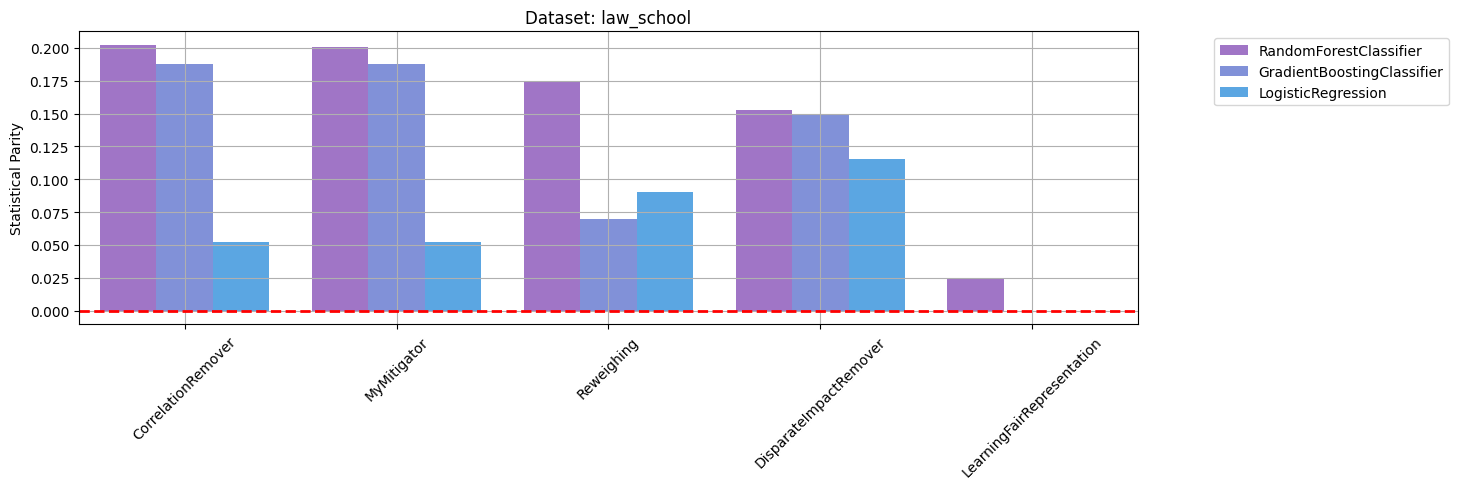

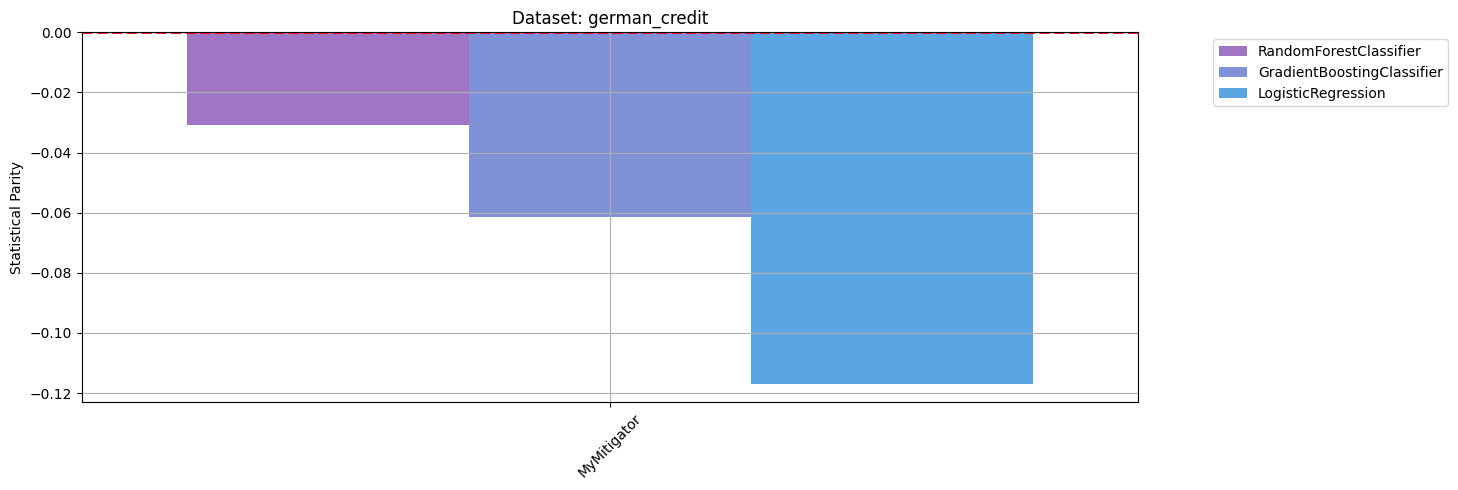

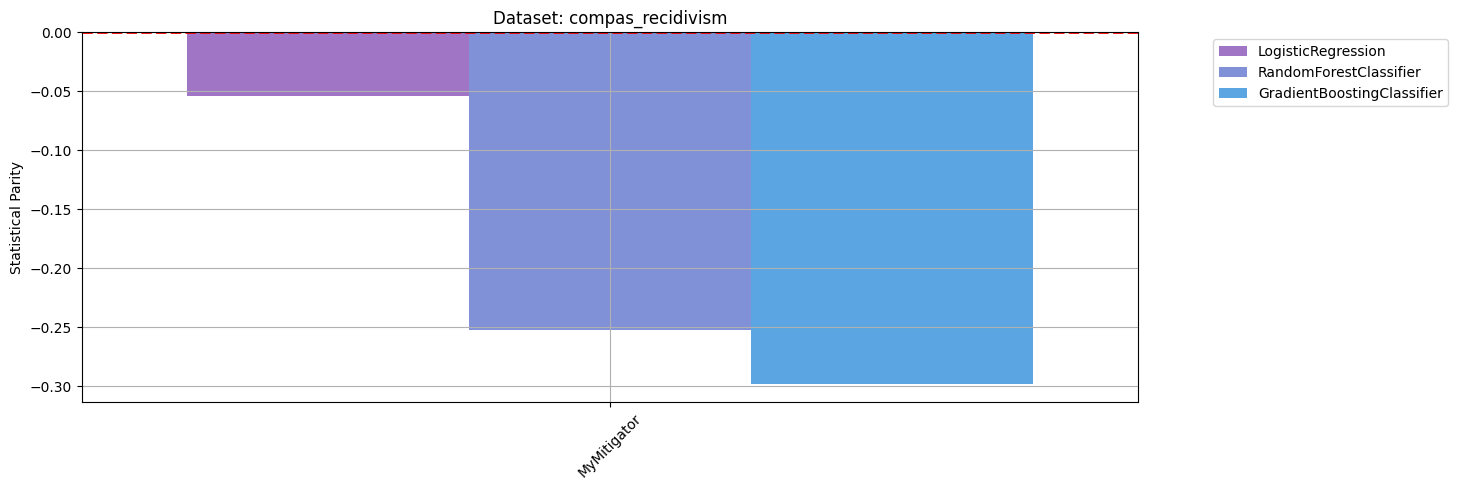

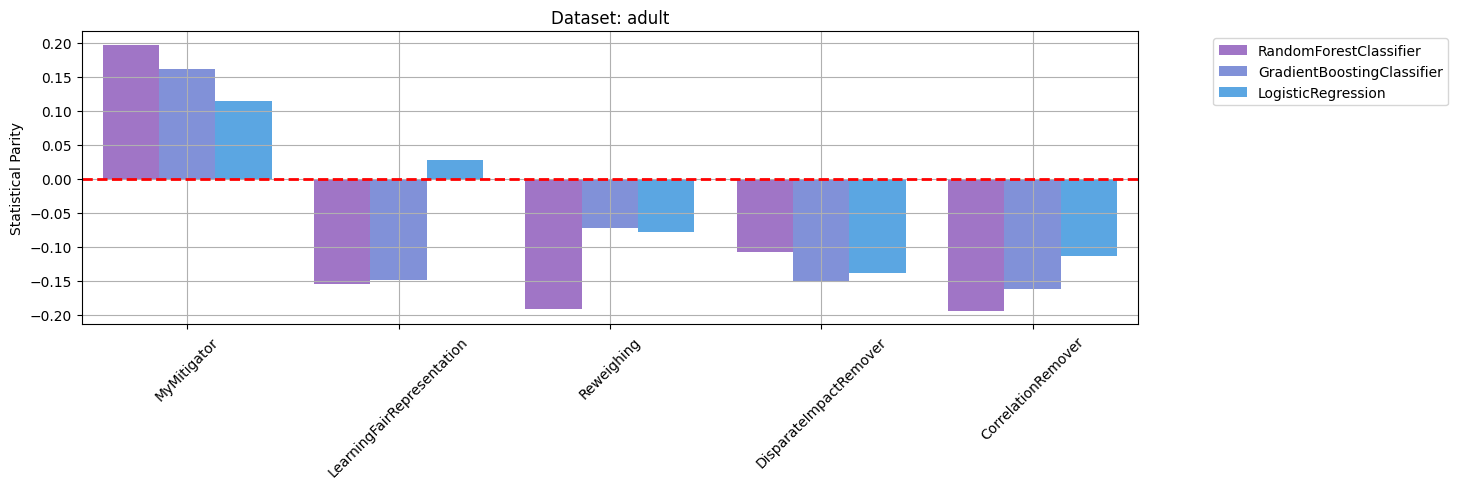

In [8]:
task.evaluate_plot()

In [9]:
task.submit()

MyMitigator benchmark submitted
MyMitigator benchmark submitted
https://holistic-ai.com/benchmark/binary_classification
